# O-net for depth estimation

### This notebook contains code to run a new depth estimation model called O-net
Done By:
Chandravaran Kunjeti
Saikumar Dande

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 40.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=5feed7112de1b42dbda42c52eb29ea034f9b14d2fef40c05d4ccfb9d6d747cc7
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Neural\ Network\ Project

/content/drive/MyDrive/Neural Network Project


In [ ]:
from DataLoader import TransposeDepthInput, NYUDataset, save_checkpoint, get_loaders, save_predictions_as_imgs
from metrics import ScaleInvariantLoss, threeshold_percentage, rmse_linear, rmse_log, abs_relative_difference, squared_relative_difference

In [ ]:
import torch
from Onet import ONET

In [ ]:
def test():
    image = torch.randn((3, 3, 120, 160))
    gradient = torch.randn((3, 2, 120, 160))
    model = ONET(in_channels1=3, in_channels2=2, out_channels=1)
    preds = model(image, gradient)
    print("Image shape\t:", image.shape)
    print("Gradient shape\t:", gradient.shape)
    print("Output shape\t:", preds.shape)
    assert preds.shape[2:] == image.shape[2:]

test()

Image shape	: torch.Size([3, 3, 120, 160])
Gradient shape	: torch.Size([3, 2, 120, 160])
Output shape	: torch.Size([3, 1, 120, 160])


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import math

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 30
NUM_WORKERS = 16
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Train/images/"
TRAIN_DEPTH_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Train/depths/"
VAL_IMG_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Validation/images/"
VAL_DEPTH_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Validation/depths/"
TEST_IMG_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Test/images/"
TEST_DEPTH_DIR = "/content/drive/MyDrive/Neural Network Project/Datasets/Test/depths/"

MODEL_NAME = 'Onet_model'
MODEL_SAVE_DIR = "/content/drive/MyDrive/Neural Network Project/Models/Onet/checkpoint/"
MODEL_LOAD_PATH = "/content/drive/MyDrive/Neural Network Project/Models/Onet/checkpoint/" + MODEL_NAME + "_10.pth.tar"
VALIDATION_IMAGES_SAVE_DIR = "/content/drive/MyDrive/Neural Network Project/Models/Onet/validation_outputs/"

dtype=torch.cuda.FloatTensor

def train_unet(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    train_loss = 0
    for batch_idx, (data, gradient, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        gradient = gradient.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        # forward
        predictions = model(data.type(dtype), gradient.type(dtype))
        loss = loss_fn(predictions, targets)

        train_loss += loss.item()
        
        # backward
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    train_loss /= (batch_idx + 1)
    return train_loss

def validate_unet(loader, model, loss_fn, epoch, train_loss, save_folder):
  loop = tqdm(loader)

  validation_loss = 0
  scale_invariant_loss = 0
  delta1_accuracy = 0
  delta2_accuracy = 0
  delta3_accuracy = 0
  rmse_linear_loss = 0
  rmse_log_loss = 0
  abs_relative_difference_loss = 0
  squared_relative_difference_loss = 0

  model.eval()
  for batch_idx, (data, gradient, targets) in enumerate(loop):
      data = data.to(device=DEVICE)
      gradient = gradient.to(device=DEVICE)
      targets = targets.to(device=DEVICE)

      with torch.no_grad():
        predictions = model(data.type(dtype), gradient.type(dtype))
        loss = loss_fn(predictions, targets)
      
      validation_loss += loss.item()

      # Error function
      scale_invariant_loss += loss_fn(predictions, targets)
      delta1_accuracy += threeshold_percentage(predictions, targets, 1.25)
      delta2_accuracy += threeshold_percentage(predictions, targets, 1.25*1.25)
      delta3_accuracy += threeshold_percentage(predictions, targets, 1.25*1.25*1.25)
      rmse_linear_loss += rmse_linear(predictions, targets)
      rmse_log_loss += rmse_log(predictions, targets)
      abs_relative_difference_loss += abs_relative_difference(predictions, targets)
      squared_relative_difference_loss += squared_relative_difference(predictions, targets)

      # Saving output depths
      targets -= torch.min(targets)
      targets = targets/torch.max(targets)

      predictions -= torch.min(predictions)
      predictions = predictions/torch.max(predictions)

      torchvision.utils.save_image(predictions, f"{save_folder}/pred_{batch_idx}.png")
      torchvision.utils.save_image(targets, f"{save_folder}{batch_idx}.png")
      
      # update tqdm loop
      loop.set_postfix(validation_loss=loss.item())
  
  validation_loss /= (batch_idx + 1)
  delta1_accuracy /= (batch_idx + 1)
  delta2_accuracy /= (batch_idx + 1)
  delta3_accuracy /= (batch_idx + 1)
  rmse_linear_loss /= (batch_idx + 1)
  rmse_log_loss /= (batch_idx + 1)
  abs_relative_difference_loss /= (batch_idx + 1)
  squared_relative_difference_loss /= (batch_idx + 1)

  print('Epoch: {}    {:.4f}      {:.4f}      {:.4f}      {:.4f}      {:.4f}      {:.4f}      {:.4f}      {:.4f}      {:.4f}'.format(epoch, train_loss, 
        validation_loss, delta1_accuracy, delta2_accuracy, delta3_accuracy, rmse_linear_loss, rmse_log_loss, 
        abs_relative_difference_loss, squared_relative_difference_loss))
  
  model.train()
  return validation_loss

def main():
    rgb_data_transforms = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
    ])

    depth_data_transforms = transforms.Compose([
        TransposeDepthInput(),
    ])

    train_loader, val_loader, test_loader = get_loaders(
          TRAIN_IMG_DIR,
          TRAIN_DEPTH_DIR,
          VAL_IMG_DIR,
          VAL_DEPTH_DIR,
          TEST_IMG_DIR,
          TEST_DEPTH_DIR,
          BATCH_SIZE,
          rgb_data_transforms,
          depth_data_transforms,
          NUM_WORKERS,
          PIN_MEMORY,
    )

    model = ONET(in_channels1=3, in_channels2=2, out_channels=1).to(DEVICE)
    loss_fn = ScaleInvariantLoss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # scaler = torch.cuda.amp.GradScaler()
    scaler = None
    
    train_losses, validation_losses = [], []

    if LOAD_MODEL:
      print("=> Loading Chekpoint")
      checkpoint = torch.load(MODEL_LOAD_PATH)
      coarse_net_model.load_state_dict(checkpoint["state_dict"])
      train_losses = checkpoint["train_losses"]
      validation_losses = checkpoint["validation_losses"]
      print("=> Checkpoint Loaded")

    print("********* Training the Unet Model **************")
    print("Epochs:     Train_loss  Val_loss    Delta_1     Delta_2     Delta_3    rmse_lin    rmse_log    abs_rel.  square_relative")
    print("Paper Val:                          (0.618)     (0.891)     (0.969)     (0.871)     (0.283)     (0.228)     (0.223)")
    
    for epoch in range(1, NUM_EPOCHS+1):
        train_loss = train_unet(train_loader, model, optimizer, loss_fn, scaler)
        validation_loss = validate_unet(val_loader, model, loss_fn, epoch, train_loss, save_folder=VALIDATION_IMAGES_SAVE_DIR)

        train_losses.append(train_loss)
        validation_losses.append(validation_loss)

        if epoch % 10 == 0:
          # save model
          checkpoint = {
              "state_dict": model.state_dict(),
              "train_losses": train_losses,
              "validation_losses": validation_losses,
          }
          save_path = MODEL_SAVE_DIR + MODEL_NAME + '_' + str(epoch) + '.pth.tar'
          save_checkpoint(checkpoint, save_path)

    print()

In [ ]:
import warnings
warnings.filterwarnings("ignore")
main()

********* Training the Unet Model **************
Epochs:     Train_loss  Val_loss    Delta_1     Delta_2     Delta_3    rmse_lin    rmse_log    abs_rel.  square_relative
Paper Val:                          (0.618)     (0.891)     (0.969)     (0.871)     (0.283)     (0.228)     (0.223)


100%|██████████| 14/14 [00:22<00:00,  1.59s/it, validation_loss=0.384]


Epoch: 1    0.2762      0.1356      0.4517      0.7749      0.9274      0.9212      0.1605      0.3613      0.5299


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.384]


Epoch: 2    0.1922      0.1246      0.5106      0.8252      0.9492      0.8410      0.1435      0.3732      0.6514


100%|██████████| 14/14 [00:15<00:00,  1.13s/it, validation_loss=0.366]


Epoch: 3    0.1822      0.1182      0.5525      0.8445      0.9480      0.8020      0.1361      0.3829      0.5984


100%|██████████| 14/14 [00:16<00:00,  1.15s/it, validation_loss=0.392]


Epoch: 4    0.1725      0.1433      0.3968      0.7288      0.9079      0.9892      0.1824      0.3612      0.5365


100%|██████████| 14/14 [00:15<00:00,  1.13s/it, validation_loss=0.358]


Epoch: 5    0.1655      0.1127      0.5501      0.8495      0.9567      0.7974      0.1281      0.3410      0.5240


100%|██████████| 14/14 [00:15<00:00,  1.14s/it, validation_loss=0.362]


Epoch: 6    0.1559      0.1144      0.5504      0.8525      0.9580      0.7915      0.1300      0.3531      0.5838


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.383]


Epoch: 7    0.1500      0.1183      0.5589      0.8525      0.9532      0.8121      0.1365      0.3984      0.7611


100%|██████████| 14/14 [00:15<00:00,  1.10s/it, validation_loss=0.377]


Epoch: 8    0.1426      0.1188      0.5087      0.8102      0.9436      0.8424      0.1423      0.3254      0.4683


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.378]


Epoch: 9    0.1344      0.1113      0.5687      0.8685      0.9639      0.7882      0.1257      0.3689      0.6698


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.415]


Epoch: 10    0.1302      0.1363      0.4726      0.7847      0.9316      0.8332      0.1614      0.3748      0.6552
=> Saving checkpoint


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.444]


Epoch: 11    0.1235      0.1542      0.4715      0.7658      0.9101      0.8549      0.1796      0.3843      0.6776


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.402]


Epoch: 12    0.1150      0.1394      0.4594      0.7575      0.9146      0.8828      0.1730      0.3460      0.5094


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.384]


Epoch: 13    0.1078      0.1224      0.4694      0.7949      0.9367      0.8694      0.1507      0.3321      0.4703


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.367]


Epoch: 14    0.0999      0.1079      0.5757      0.8746      0.9620      0.7546      0.1233      0.3575      0.6370


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.469]


Epoch: 15    0.0982      0.1731      0.4716      0.7798      0.9122      0.9637      0.1974      0.4372      0.7098


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.364]


Epoch: 16    0.0905      0.1057      0.5803      0.8704      0.9615      0.7461      0.1196      0.3321      0.5496


100%|██████████| 14/14 [00:15<00:00,  1.14s/it, validation_loss=0.372]


Epoch: 17    0.0840      0.1099      0.5775      0.8776      0.9600      0.7720      0.1240      0.3529      0.6161


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.356]


Epoch: 18    0.0801      0.1069      0.5861      0.8692      0.9587      0.7558      0.1206      0.3309      0.5269


100%|██████████| 14/14 [00:15<00:00,  1.09s/it, validation_loss=0.399]


Epoch: 19    0.0763      0.1137      0.5670      0.8638      0.9622      0.7635      0.1277      0.3608      0.6926


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.366]


Epoch: 20    0.0739      0.1113      0.5126      0.8272      0.9542      0.8171      0.1332      0.3197      0.4615
=> Saving checkpoint


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.372]


Epoch: 21    0.0719      0.1077      0.5606      0.8593      0.9625      0.7594      0.1240      0.3275      0.5403


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.376]


Epoch: 22    0.0685      0.1149      0.5075      0.8197      0.9523      0.8144      0.1385      0.3290      0.5022


100%|██████████| 14/14 [00:15<00:00,  1.09s/it, validation_loss=0.547]


Epoch: 23    0.0655      0.2077      0.3724      0.6492      0.8306      0.9670      0.2617      0.4143      0.7247


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.391]


Epoch: 24    0.0656      0.1121      0.5406      0.8429      0.9573      0.7743      0.1308      0.3311      0.5355


100%|██████████| 14/14 [00:15<00:00,  1.13s/it, validation_loss=0.376]


Epoch: 25    0.0619      0.1057      0.5686      0.8652      0.9644      0.7513      0.1216      0.3256      0.5483


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.381]


Epoch: 26    0.0579      0.1084      0.5493      0.8482      0.9588      0.7660      0.1278      0.3241      0.5183


100%|██████████| 14/14 [00:15<00:00,  1.11s/it, validation_loss=0.369]


Epoch: 27    0.0582      0.1017      0.6126      0.8907      0.9660      0.7137      0.1138      0.3394      0.5966


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.399]


Epoch: 28    0.0541      0.1107      0.5767      0.8600      0.9604      0.7526      0.1256      0.3376      0.6100


100%|██████████| 14/14 [00:15<00:00,  1.13s/it, validation_loss=0.379]


Epoch: 29    0.0537      0.1132      0.5267      0.8375      0.9539      0.7916      0.1333      0.3318      0.5252


100%|██████████| 14/14 [00:15<00:00,  1.12s/it, validation_loss=0.366]


Epoch: 30    0.0514      0.1048      0.5965      0.8798      0.9645      0.7343      0.1165      0.3392      0.5781
=> Saving checkpoint



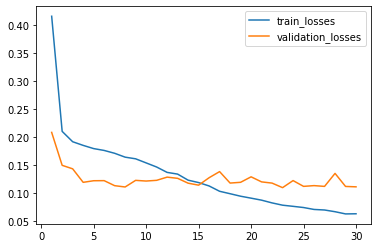

In [ ]:
import matplotlib.pyplot as plt

UNET_MODEL_PATH = "/content/drive/MyDrive/Neural Network Project/Datasets/NYU/Unet_Models/unet_model_30.pth.tar"

unet_checkpoint = torch.load(UNET_MODEL_PATH)
unet_train_losses = unet_checkpoint["train_losses"]
unet_validation_losses = unet_checkpoint["validation_losses"]

x = [i for i in range(1, len(train_losses)+1)]
plt.plot(x, unet_train_losses, label = "train_losses")
plt.plot(x, unet_validation_losses, label = "validation_losses")
plt.legend()
plt.show()

### **Testing**

In [ ]:
%cd /content/drive/MyDrive/Neural\ Network\ Project

/content/drive/MyDrive/Neural Network Project


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch
from Onet import ONET
from DataLoader import TransposeDepthInput, NYUDataset, save_checkpoint, get_loaders, save_predictions_as_imgs
from metrics import ScaleInvariantLoss, threeshold_percentage, rmse_linear, rmse_log, abs_relative_difference, squared_relative_difference

In [ ]:
IMAGE_HEIGHT = 120
IMAGE_WIDTH = 160

rgb_data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
])

In [ ]:
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ONET_MODEL_PATH = "Models/Onet/checkpoint/Onet_model_90_cv.pth.tar"
TRAIN_SAVE_PATH = "Models/Onet/predictions/Train/"
VAL_SAVE_PATH = "Models/Onet/predictions/Validation/"
TEST_SAVE_PATH = "Models/Onet/predictions/Test/"

TRAIN_IMG_DIR = "Datasets/Train/images/"
TRAIN_DEPTH_DIR = "Datasets/Train/depths/"
VAL_IMG_DIR = "Datasets/Validation/images/"
VAL_DEPTH_DIR = "Datasets/Validation/depths/"
TEST_IMG_DIR = "Datasets/Test/images/"
TEST_DEPTH_DIR = "Datasets/Test/depths/"

model = ONET(in_channels1=3, in_channels2=2, out_channels=1).to(DEVICE)

# Loading Unet model
checkpoint = torch.load(ONET_MODEL_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [ ]:
def Save_Predictions(image_dir, depth_dir, save_dir):
    model.eval()
    for image_name in os.listdir(image_dir):
        # Load the image and dpeth
        image = cv2.imread(image_dir + image_name, cv2.IMREAD_UNCHANGED)
        depth = cv2.imread(depth_dir+ image_name, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = rgb_data_transforms(image)

        # Find the gradient
        gray = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
        gx = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx=1, dy=0, ksize=3)
        gy = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx=0, dy=1, ksize=3)
        gradient = torch.from_numpy(np.stack([gx, gy]))

        image = torch.unsqueeze(image, 0)
        gradient = torch.unsqueeze(gradient, 0)

        # Predict the output
        image = image.to(device=DEVICE)
        gradient = gradient.to(device=DEVICE)
        with torch.no_grad():
            predicted = model(image, gradient)

        image = image.cpu()
        predicted = predicted.cpu()

        input_image = np.zeros((120, 160, 3), dtype=np.float32)
        input_image[:, :, 0] = image[0, 0, :, :]
        input_image[:, :, 1] = image[0, 1, :, :]
        input_image[:, :, 2] = image[0, 2, :, :]
        predicted = predicted[0, 0, :, :]

        fig = plt.figure(figsize=(14, 6))

        ax = fig.add_subplot(1, 3, 1)
        ax.set_title('Input image')
        plt.imshow(input_image)
        ax = fig.add_subplot(1, 3, 2)
        ax.set_title('Ground truth')
        plt.imshow(depth, cmap='gist_gray')    #plt.imshow(actual_depth, cmap='jet')
        ax = fig.add_subplot(1, 3, 3)
        ax.set_title('Onet predicted')
        plt.imshow(predicted, cmap='gist_gray')
        plt.savefig(f'{save_dir}/{image_name}')
        plt.close(fig)
        
    model.train()

In [ ]:
Save_Predictions(VAL_IMG_DIR, VAL_DEPTH_DIR, VAL_SAVE_PATH)

In [ ]:
Save_Predictions(TRAIN_IMG_DIR, TRAIN_DEPTH_DIR, TRAIN_SAVE_PATH)

In [ ]:
Save_Predictions(TEST_IMG_DIR, TEST_DEPTH_DIR, TEST_SAVE_PATH)

### **Time taken**

In [ ]:
import time
model.eval()
start_time = time.time()
num_images = 50
time_taken = 0
for i in range(num_images):
    image = cv2.imread(TRAIN_IMG_DIR + str(i) + '.png', cv2.IMREAD_UNCHANGED)
    depth = cv2.imread(TRAIN_DEPTH_DIR + str(i) + '.png', cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    image = rgb_data_transforms(image)

    # Find the gradient
    gray = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    gx = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx=1, dy=0, ksize=3)
    gy = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx=0, dy=1, ksize=3)
    gradient = torch.from_numpy(np.stack([gx, gy]))

    image = torch.unsqueeze(image, 0)
    gradient = torch.unsqueeze(gradient, 0)

    # Predict the output
    image = image.to(device=DEVICE)
    gradient = gradient.to(device=DEVICE)
    with torch.no_grad():
        start_time1 = time.time()
        predicted = model(image, gradient)
        end_time1 = time.time()
    time_taken += (end_time1 - start_time1)
end_time = time.time()
model.train()
print('Time taken:', (end_time-start_time)/num_images)
print('Time taken:', (time_taken)/num_images)

Time taken: 0.10464584827423096
Time taken: 0.010366077423095704


### **Model summary**

In [ ]:
print(model)

ONET(
  (ups): ModuleList()
  (downs1): DownConv(
    (downs): ModuleList(
      (0): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, 

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|   downs1.downs.0.conv.0.weight  |    1728    |
|   downs1.downs.0.conv.1.weight  |     64     |
|    downs1.downs.0.conv.1.bias   |     64     |
|   downs1.downs.0.conv.3.weight  |   36864    |
|   downs1.downs.0.conv.4.weight  |     64     |
|    downs1.downs.0.conv.4.bias   |     64     |
|   downs1.downs.1.conv.0.weight  |   73728    |
|   downs1.downs.1.conv.1.weight  |    128     |
|    downs1.downs.1.conv.1.bias   |    128     |
|   downs1.downs.1.conv.3.weight  |   147456   |
|   downs1.downs.1.conv.4.weight  |    128     |
|    downs1.downs.1.conv.4.bias   |    128     |
|   downs1.downs.2.conv.0.weight  |   294912   |
|   downs1.downs.2.conv.1.weight  |    256     |
|    downs1.downs.2.conv.1.bias   |    256     |
|   downs1.downs.2.conv.3.weight  |   589824   |
|   downs1.downs.2.conv.4.weight  |    256     |
|    downs1.downs.2.

68341569